In [1]:
import torch
from torch import nn
from torch.nn import functional
from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, DataCollatorWithPadding
import torch.optim as optim

from dataset.create_dataset import create_data_loader
from model.model import Transformer
from transformers import BertTokenizer

from test_model.test_model import TestModel
from tqdm import tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = Transformer(num_heads=8,
                    embedding_size=512,
                    num_blocks=6,
                    max_sequence_len=1024,
                    vocab_size=tokenizer.vocab_size,
                    output_size=3).to(device)

model.requires_grad = True

In [4]:
train_dataloader, test_dataloader, _ = create_data_loader(batch_size=8,
                                    max_sequence_size=1024,
                                    tokenizer=tokenizer)

Found cached dataset financial_phrasebank (C:/Users/skoro/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/550bde12e6c30e2674da973a55f57edde5181d53f5a5a34c1531c53f93b7e141)


  0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/3876 [00:00<?, ? examples/s]

Map:   0%|          | 0/970 [00:00<?, ? examples/s]

In [5]:
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
model_tester = TestModel()

In [7]:
history = {}

metrics_data = model_tester(model, test_dataloader, 3)

for metric_name, metric_value in metrics_data.items():
    if metric_name not in history:
        history[metric_name] = []
    history[metric_name].append(metric_value)

In [8]:
def train(history):
    model.train()
    for batch in test_dataloader:
        
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)

        model_outputs = model(input_ids)

        loss = loss_function(model_outputs, labels)

        loss.backward()

        optimizer.step()
    
    metrics_data = model_tester(model, test_dataloader, 3)

    for metric_name, metric_value in metrics_data.items():
        if metric_name not in history:
            history[metric_name] = []
        history[metric_name].append(metric_value)


In [9]:
num_epochs = 1

for epoch in tqdm(range(num_epochs), desc='Epochs'):
    train(history)

Epochs: 100%|██████████| 1/1 [04:00<00:00, 240.31s/it]


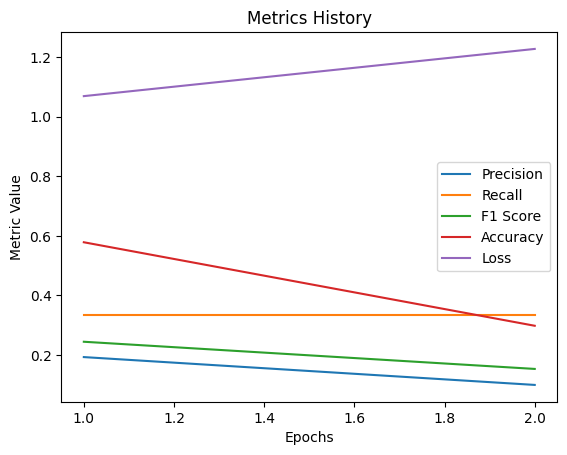

In [10]:
import matplotlib.pyplot as plt

epochs = range(1, len(history['precision']) + 1)

plt.plot(epochs, history['precision'], label='Precision')
plt.plot(epochs, history['recall'], label='Recall')
plt.plot(epochs, history['f1'], label='F1 Score')
plt.plot(epochs, history['accuracy'], label='Accuracy')
plt.plot(epochs, history['loss'], label='Loss')

plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('Metrics History')

plt.legend()

plt.show()